# **Tutorial of Image Classification on Original Dataset**

**You will learn about basic classification method using skin image data on EfficientNet with Pytorch through this tutorial**
    
This dataset contains 4 class images that divided for training and test into 8:2 (please check the dataset folders out)

* class 1: 1540 images
* class 2: 3101 images
* class 3: 1407 images
* class 4: 1006 images




**Image samples**

*  classe 1

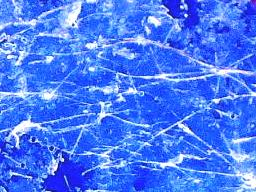

*   classe 2

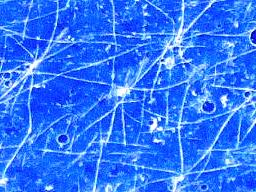

*   classe 3

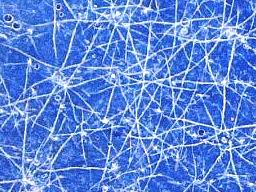

*   classe 4

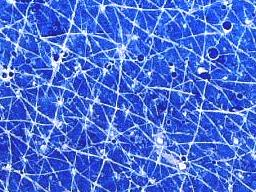

**1. mount your google drive**

*   Before training, upload dataset as zip file to Google drive.

*   Please mount your google drive for loading dataset, saving results and trained model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2. unzip the data**

This is structure of skin image dataset
*   Train/
    *   class 1/ images...
    *   class 2/ images...
    *   class 3/ images...
    *   class 4/ images...
*   test/
    *   class 1/ images...
    *   class 2/ images...
    *   class 3/ images...
    *   class 4/ images...


In [ ]:
!unzip "drive/My Drive/data/skin_1/org.zip"
#please change to the name of your data folder
data_folder = "org/"

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: __MACOSX/org/train/2/._1093479951_20191108_00664184.JPG  
  inflating: org/train/2/1094465787_20200325_00685589.JPG  
  inflating: __MACOSX/org/train/2/._1094465787_20200325_00685589.JPG  
  inflating: org/train/2/1094534856_20200215_00678839.JPG  
  inflating: __MACOSX/org/train/2/._1094534856_20200215_00678839.JPG  
  inflating: org/train/2/1073495268_20200327_00686454.JPG  
  inflating: __MACOSX/org/train/2/._1073495268_20200327_00686454.JPG  
  inflating: org/train/2/1093838315_20191117_00665834.JPG  
  inflating: __MACOSX/org/train/2/._1093838315_20191117_00665834.JPG  
  inflating: org/train/2/1094629083_20200307_00683943.JPG  
  inflating: __MACOSX/org/train/2/._1094629083_20200307_00683943.JPG  
  inflating: org/train/2/1093990038_20191128_00667498.JPG  
  inflating: __MACOSX/org/train/2/._1093990038_20191128_00667498.JPG  
  inflating: org/train/2/1056139106_20200123_00676046.JPG  
  inflating: __MACOSX/org/train/2/._1056139106_2020

**3. download the liblary of EfficientNet**

Install a model what you want to use!

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=f8f2069904edcf2a6dad15ec95332ee85e96394aacd75cf62bedb25740860615
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


**4. import liblaries**

Import some liblaries for training of model.

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import random
import collections
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
from tqdm.notebook import tqdm
import math
import re

**5. parameter settings**

In [ ]:
#the number of classes of the dataset
num_classes = 4
#the number of images in a iteration
batch_size = 64
#the number of minibatch once a loading
workers = 8
#Epochs
epochs = 200
#Learning rate
lr = 0.001
#momentum for optimazation
momentum = 0.9
#weight decay for regularization
decay = 0.0005
#for update learning rate: new lr= lr*gamma
gamma = 0.2
#use cuda or not
no_cuda = False
#whether save model
save_model = True
#the size of input image size
data_size = 192

#the name of model
model_name = 'efficientnet-b0'

#To save the result and model
# path on google colab 
save_path = 'data'
# path on google drive
save_path_onGoogleDrive = "drive/My Drive/data/model/" + model_name
os.makedirs(save_path, exist_ok=True)
os.makedirs(save_path_onGoogleDrive, exist_ok=True)


**DataLoader**

    When you treat another dataset, please change "__init__" function to fit the structure of your data folder.

    1. __init__ :
        This function loads data from "data_folder" and save all images in the folder to "self.file" (for image) and "self.label" (for label). 
        
        *Please save image and label to the same index of both array.

    2. __len__:
        This function return the number of data.

    3. __getitem__(i):
        This function return image and label of index 'i'.
        Before return image and label, please transform to tensor type througth transformer function.

In [ ]:
class Create_Dataset(Dataset):
    def __init__(self,data_folder, transform, num_classes=1000, train=True):
        self.file=[]
        self.label=[]
        if train:
          for i in range(num_classes):
            files = os.listdir(data_folder+'train/'+str(i+1))
            for j in files:
              if 'JPG' in j:
                self.file.append(data_folder+'train/'+str(i+1)+'/'+j)
                self.label.append(i)
        else:
          for i in range(num_classes):
            files = os.listdir(data_folder+'test/'+str(i+1))
            for j in files:
              if 'JPG' in j:
                self.file.append(data_folder+'test/'+str(i+1)+'/'+j)
                self.label.append(i)
        self.data_transform = transform
        self.train = train
    def __len__(self):
        return len(self.file)
    def __getitem__(self, i):
        file = self.file[i]
        label = self.label[i]
        image = Image.open(file)
        #image = image.convert("L")
        image = self.data_transform(image)
        return image, label

**Training finction**

    This function train model by using train data

In [ ]:
def train(model, dataloader, optimizer, criterion, device):
  #train mode
  model.train()
  #load data
  for (data, target) in tqdm(dataloader):
    #replace data to gpu from cpu
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    # get output of model
    output = model(data)
    #calcurate loss
    loss = criterion(output, target)
    #ajust parameters
    loss.backward()
    optimizer.step()

**Test function**

    This function test trained model by using train/test data

    Get the loss and accuracy of network

In [ ]:
def test(model, dataloader, criterion, loss_value, acc_value, batch_size, device):
    sum_loss = 0.0
    sum_correct = 0
    sum_total = 0
    model.eval()
    for (data, target) in dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        sum_loss += loss.item()
        _, predicted = output.max(1)
        sum_total += target.size(0)
        sum_correct += (predicted == target).sum().item()
        print("mean loss={}, accuracy={}".format(sum_loss*batch_size/len(dataloader.dataset), float(sum_correct/sum_total)))
    loss_value.append(sum_loss*batch_size/len(dataloader.dataset))
    acc_value.append(float(sum_correct/sum_total))

**Function for plotting loss and accuracy**

    This function make some figures of train/test loss and accuracy.

In [ ]:
def plot_data(epoch, train_loss_value, train_acc_value, test_loss_value, test_acc_value, save_path)

    plt.figure(figsize=(6,6))
    plt.plot(range(epoch), train_loss_value)
    plt.plot(range(epoch), test_loss_value)
    plt.legend(['train loss', 'test loss'])
    plt.title('loss')
    plt.savefig(save_path+"/loss.png")

    plt.clf()

    plt.plot(range(epoch), train_acc_value)
    plt.plot(range(epoch), test_acc_value)
    plt.legend(['train acc', 'test acc'])
    plt.title('top-1 accuracy')
    plt.savefig(save_path+"/accuracy.png")
    plt.close()

**Save trained model**

    This function save a model

In [ ]:
def save_model(model,model_name,save_path):
    torch.save(model.state_dict(), save_path+"/model_"+model_name+".pt")

**6. CPU or CUDA**

In [ ]:
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("device: %s"%device)

**7. Load data**

In [ ]:
#data augmentation for training images
transform_train = transforms.Compose([
#random crop
transforms.RandomCrop(data_size, padding = 4),
#random rotation
transforms.RandomRotation(degrees=180),
#random horizontal flip
transforms.RandomHorizontalFlip(),
#transform a data to tensorflow
transforms.ToTensor(),
#nomalize a data
transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
#random eracing
transforms.RandomErasing(),
])
#data augmentation for testining images
transform_test = transforms.Compose([
#transform a data to tensorflow
    transforms.ToTensor(),
#nomalize a data
transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ])

#load data
trainset = Create_Dataset(data_folder=data_folder, num_classes=num_classes,transform=transform_train,train=True)
testset = Create_Dataset(data_folder=data_folder, num_classes=num_classes,transform=transform_test,train=False)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=workers)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False, num_workers=workers)

print("the number of train images: %d"%len(trainset))
print("the number of test images: %d"%len(testset))

**8. Train model and test trained model**

In [ ]:
#load model
net = EfficientNet.from_pretrained(model_name, num_classes=num_classes).to(device)
#define the calcuration for loss
criterion = nn.CrossEntropyLoss()
#optimizer
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
#scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80,160], gamma=gamma)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(epochs/3), gamma=gamma)

#train and test 
train_loss_value=[]
train_acc_value=[]
test_loss_value=[]
test_acc_value=[]
for epoch in range(1, epochs + 1):
    print("epoch: %d"%(epoch))
    #train
    train(net, trainloader, optimizer, criterion, device)
    print("train ",end="")
    #test train data
    test(net, trainloader, criterion, train_loss_value, train_acc_value, batch_size, device)
    print("test ",end="")
    #test test data
    test(net, testloader, criterion, test_loss_value, test_acc_value, batch_size, device)
    scheduler.step()

    #plot results
    plot_data(epoch, train_loss_value, train_acc_value, test_loss_value, test_acc_value, save_path)
    plot_data(epoch, train_loss_value, train_acc_value, test_loss_value, test_acc_value, save_path_onGoogleDrive)
    #save model
    if save_model:
      save_model(net,model_name,save_path)
      save_model(net,model_name,save_path_onGoogleDrive)